# Model Analysis

## Introduction

First of all, we import all the libraries that are required to run this whole notebook.

In [1]:
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quiniela import io
import datetime
from statistics import mean

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import seaborn as sns

After some analysis about how the different possible features affect the training of the model and the prediction of new results, we have decided that we will work with the following ones:

In [2]:
features = ['season', 'division', 'matchday', 'weekday', 'time', 'team', 'rival', 'last_5_results_local','last_5_results_rival']
target = "winner"

In earlier models, we tried to use both the rank and the goals scored by the teams; the results achieved were really good, but we realized that the model gave a lot of importance to these features.   
Obviously, the model could know what the result of the match had been depending on the goals that each team had scored in that matchday or if its rank had increased or not.     
Although it could give some really useful information in order to predict new results, outside of the data used for the training, the model really took them as the most important features, giving to the others much less importance. Afterwards, as the model couldn't know this "future" information to predict new matches, the results were worse.

On the other hand, what we use is a numbered quantity of the last results of the matches. Even though it could also give the model information about the future during the training, the importance given to it is quite small compared to others, so the model doesn't fail so much predicting new results.

The dataset that we use to train our model is the following one:

In [3]:
def encoder_teams():
    seasons =  ["2010-2011", "2011-2012", "2012-2013", "2013-2014",
                "2014-2015","2015-2016", "2016-2017", "2017-2018",
                "2018-2019", "2019-2020", "2020-2021", "2021-2022"]
    data = io.load_historical_data(seasons)
    
    team_names = data['home_team'].unique()
    team_ids = [i for i in range(len(team_names))]
    
    return team_names, team_ids


Every season, the clubs playing in the 1st division change; universalizing the encoding across all these seasons, we associate a unique number to each unique club.

Moreover, we worked using the latest seasons because these tell a more reliable story about each club, hence improving the credibility of the prediction.   
To make an example: if we trained the model using seasons form early 2000s, it could have predicted Deportivo La Coruña to be a top team, which is of course unrealistic in 2023.

## The training dataset

Auxiliary functions:

In [4]:
def weekday_match(date):
    month, day, year = map(int, date.split('/'))
    year += 2000
    
    n_weekday = datetime.date(year, month, day).weekday()
    return n_weekday

def determine_winner(row):
    if row['local_goals'] > row['visitor_goals']:
        return 'Local'
    elif row['local_goals'] < row['visitor_goals']:
        return 'Visitor'
    else:
        return 'Tie'
    
def match_result(row):
    if row['W_match'] == True:
        return 'W'
    elif row['L_match'] == True:
        return 'L'
    elif row['T_match'] == True:
        return 'T'
    
def numerical_time(time_string):
    if time_string is None:
        time_string = "12:00 AM"
    time_parts = datetime.datetime.strptime(time_string, "%I:%M %p")
    time_num = time_parts.hour + time_parts.minute / 60
    return time_num

def numerical_last_results_local(last_results_list):
    total = 0
    for result in last_results_list:
        if result == 'W':
            total += 3
        elif result == 'T':
            total += 1
        else:
            total += -3
    return total


A function to prepare the dataset:

In [5]:
def preparing_training_dataset():
    seasons = ["2010-2011", "2011-2012", "2012-2013", "2013-2014", 
               "2014-2015", "2015-2016", "2016-2017", "2017-2018", 
               "2018-2019", "2019-2020", "2020-2021"]
    data = io.load_historical_data(seasons)
    data[['local_goals', 'visitor_goals']] = data['score'].str.split(':', expand=True).astype(float)
    data['winner'] = data.apply(determine_winner, axis=1)
    data['goal_difference'] = data['local_goals'] - data['visitor_goals']
    data['weekday'] = data['date'].apply(weekday_match)
    
    home_team_df = data.copy()
    home_team_df['team'], home_team_df['rival'], home_team_df['condition'] = home_team_df['home_team'], home_team_df['away_team'], 'local'
    away_team_df = data.copy()
    away_team_df['team'], away_team_df['rival'], away_team_df['condition']= away_team_df['away_team'], away_team_df['home_team'], 'visitor'
    
    matches_data = pd.concat([home_team_df, away_team_df], ignore_index=True).sort_values(by=['season', 'division', 'team', 'matchday'])
    matches_data.reset_index(drop=True, inplace=True)
    
    matches_data['GF_match'] = matches_data.apply(lambda row: row['local_goals'] if row['condition'] == 'local' else row['visitor_goals'], axis=1)
    matches_data['GA_match'] = matches_data.apply(lambda row: row['visitor_goals'] if row['condition'] == 'local' else row['local_goals'], axis=1)
    matches_data['GD_match'] = matches_data['GF_match'] - matches_data['GA_match']
    matches_data['W_match'] = ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'visitor'))
    matches_data['L_match'] = ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'visitor'))
    matches_data['T_match'] = (matches_data['winner'] == 'Tie')
    matches_data['match_result'] = matches_data.apply(match_result, axis=1)
    matches_data['last_match_result_1'] = matches_data.groupby(['season', 'team'])['match_result'].shift(1)
    matches_data['last_match_result_2'] = matches_data.groupby(['season', 'team'])['match_result'].shift(2)
    matches_data['last_match_result_3'] = matches_data.groupby(['season', 'team'])['match_result'].shift(3)
    matches_data['last_match_result_4'] = matches_data.groupby(['season', 'team'])['match_result'].shift(4)
    matches_data['last_match_result_5'] = matches_data.groupby(['season', 'team'])['match_result'].shift(5)
    matches_data['last_5_results_local'] = matches_data[['last_match_result_1', 'last_match_result_2', 'last_match_result_3', 
                                                'last_match_result_4', 'last_match_result_5']].values.tolist()

    matches_data['GF'] = matches_data.groupby(['season', 'team'])['GF_match'].cumsum()
    matches_data['GA'] = matches_data.groupby(['season', 'team'])['GA_match'].cumsum()
    matches_data['W'] = matches_data.groupby(['season', 'team'])['W_match'].cumsum()
    matches_data['L'] = matches_data.groupby(['season', 'team'])['L_match'].cumsum()
    matches_data['T'] = matches_data.groupby(['season', 'team'])['T_match'].cumsum()
    
    final_ranking = matches_data.reset_index()
    final_ranking['GD'] = final_ranking['GF'] - final_ranking['GA']
    final_ranking['Pts'] = final_ranking['W'] * 3 + final_ranking['T']
    final_ranking = final_ranking.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD'], ascending=[False, True, True, False, False])
    final_ranking.reset_index(drop=True, inplace=True)
    final_ranking['rank'] = final_ranking.groupby(['season', 'division', 'matchday'])['Pts'].rank(ascending=False, method='first').astype(int)
    
    final_ranking = final_ranking[['season', 'division', 'matchday', 'weekday', 'time', 'rank', 'team', 'rival', 'condition', 'winner', 'GF_match', 'GA_match', 'GD_match', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'last_5_results_local']]
    
    ### Prepare numerical data
    #season
    seasons_string = final_ranking['season'].unique()
    seasons_list = list(reversed(range(2010, 2021)))
    final_ranking['season'] = final_ranking['season'].replace(seasons_string, seasons_list)
    #time
    final_ranking['time'] = final_ranking['time'].apply(numerical_time)
    #team / rival
    team_names, team_ids = encoder_teams()
    final_ranking[['team', 'rival']] = final_ranking[['team', 'rival']].replace(team_names, team_ids)
    
    #winner --> 0: Local, 1: Tie, 2:Visitor
    final_ranking['winner'] = final_ranking['winner'].replace(['Local', 'Tie', 'Visitor'], [0, 1, 2])
    #last 5 results
    final_ranking['last_5_results_local'] = final_ranking['last_5_results_local'].apply(numerical_last_results_local)
    mapping = final_ranking.groupby(['season', 'matchday']).apply(lambda x: dict(zip(x['team'], x['last_5_results_local']))).to_dict()
    final_ranking['last_5_results_rival'] = final_ranking.apply(lambda row: mapping.get((row['season'], row['matchday']), {}).get(row['rival'], None), axis=1)
    
    # The matches are repeated: Drop when condition is Visitor
    final_ranking = final_ranking.loc[final_ranking['condition'] == 'local']

    return final_ranking



Preparing the dataset:

In [6]:
training_dataset = preparing_training_dataset()
training_dataset

,season,division,matchday,weekday,time,rank,team,rival,condition,winner,...,GD_match,GF,GA,GD,W,L,T,Pts,last_5_results_local,last_5_results_rival
0,2020,1,1,2,19.0,1,10,25,local,0,...,3.0,3.0,0.0,3.0,1,0,0,3,-15,-15
1,2020,1,1,1,21.5,2,9,18,local,0,...,2.0,2.0,0.0,2.0,1,0,0,3,-15,-15
3,2020,1,1,5,18.5,4,22,13,local,0,...,2.0,2.0,0.0,2.0,1,0,0,3,-15,-15
4,2020,1,1,1,21.0,5,12,14,local,0,...,2.0,2.0,0.0,2.0,1,0,0,3,-15,-15
5,2020,1,1,6,21.0,6,11,2,local,0,...,2.0,4.0,2.0,2.0,1,0,0,3,-15,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18513,2010,2,42,5,20.0,12,41,22,local,1,...,0.0,44.0,37.0,7.0,12,10,20,56,-1,7
18516,2010,2,42,5,18.0,15,28,44,local,0,...,1.0,56.0,71.0,-15.0,13,14,15,54,1,7
18520,2010,2,42,5,18.0,19,35,43,local,1,...,0.0,46.0,68.0,-22.0,13,22,7,46,1,11
18522,2010,2,42,5,18.0,21,34,39,local,1,...,0.0,36.0,63.0,-27.0,5,18,19,34,3,-3


As it can be noticed, all the "non-numerical" data (season, winner, ...) has been converted to a numerical one; otherwise, we couldn't use it to train the model.

The numbers of the teams have been assigned quite randomly. Instead of using encoding tools like OneHotEncoder, we have considered that these codified values won't affect so much our model, as it's not that important for this kind of tree-model.

Another thing that must be mentioned here is the encoding we have used for the target column _winner;_  
we have used 0 when the winner is the local team, 1 when there is a tie and 2 when the visitor team wins. After all that, we will have to convert these results in a more understandable way. Same goes for the team names.


## The Random Forest Classifier

Splitting the dataset in training and testing set:

In [7]:
X, y = training_dataset[features], training_dataset[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=15)
rf_model.fit(X_train, y_train)
rf_model_y_pred = rf_model.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, rf_model_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, rf_model_y_pred)}")
print(f"R^2: {r2_score(y_test, rf_model_y_pred)}")

RMSE: 1.1201437730555683
MAPE: 189574080375013.2
R^2: -0.8348503704006567


We have chosen to use a **Random Forest Classifier**, tuning the hyperparameters.   

1. We had to work with an ensemble of type Classifier and not Regressor, as the data we are trying to predict is discrete, and not continuous.
2. We chose this model after a lot of testing with others type of ensembles, and also trying with different hyperparameters. 

>The Sklearn library offers other options such as the Gradient Boosting Classifier and the Bagging Classifier. We have even tried a model that was a combination of different models, which is the Voting Classifier. This last one combines different models and the prediction it makes is - shortly speaking - the most voted option between the models that are combined. Even though you can obviously tune this model, giving more importance to some models rather than others, or changing the way the "votation" is done, the results offered by all these models were always the same or a little worse. 

- In fact, the Random Forest Classifier is the worst at predicting ties - but it's really good predicting home wins, which is the most frequent result.  
- Regarding predicting the losses, all the models were quite bad.
- In general, this model offered better results during the testing of different models.

We have trained all the models with the seasons from "2010-2011" to "2019-2020". This way, we could try to predict the results of the whole "2020-2021" season and have a better idea of which model worked best. After trying some variants of the Classifier models presented, and also some combinations in a Voting Classifier, looking at some plots such as: boxplot and histograms about their accuracy, their confusion matrices, and an histogram of the predictions to look for the tendency and behaviour of our models, we have decided that the models that fits the best here is the Random Forest Boosting.  

After increasing the number of estimators and the maximum depth, and checking whether the model needed more time to train, we decided to tune the hyperparameters; this could have drastically increased the training time, or - worse - it could have caused the model to overfit.  
Luckily enough, this maneuver actually resulted in a good improvement of the model.

## The testing dataset

So, before presenting the evaluation of our model, we will show how it predicts the expected matchday. Then, the dataset that we will use to see this predictions in the following one:

as before, let's define a few auxiliary functions and prepare the dataset:

In [9]:
def weekday_match(date):
    month, day, year = map(int, date.split('/'))
    year += 2000
    
    n_weekday = datetime.date(year, month, day).weekday()
    return n_weekday

def determine_winner(row):
    if row['local_goals'] > row['visitor_goals']:
        return 'Local'
    elif row['local_goals'] < row['visitor_goals']:
        return 'Visitor'
    else:
        return 'Tie'
    
def match_result(row):
    if row['W_match'] == True:
        return 'W'
    elif row['L_match'] == True:
        return 'L'
    elif row['T_match'] == True:
        return 'T'
    
def numerical_time(time_string):
    if time_string is None:
        time_string = "12:00 AM"
    time_parts = datetime.datetime.strptime(time_string, "%I:%M %p")
    time_num = time_parts.hour + time_parts.minute / 60
    return time_num

def numerical_last_results_local(last_results_list):
    total = 0
    for result in last_results_list:
        if result == 'W':
            total += 3
        elif result == 'T':
            total += 1
        else:
            total += -3
    return total


In [10]:
def preparing_predicting_dataset():
    data = io.load_historical_data("all")
    data = data.loc[data['season'] == "2021-2022"]
    data[['local_goals', 'visitor_goals']] = data['score'].str.split(':', expand=True).astype(float)
    data['winner'] = data.apply(determine_winner, axis=1)
    data['goal_difference'] = data['local_goals'] - data['visitor_goals']
    data['weekday'] = data['date'].apply(weekday_match)
    
    home_team_df = data.copy()
    home_team_df['team'], home_team_df['rival'], home_team_df['condition'] = home_team_df['home_team'], home_team_df['away_team'], 'local'
    away_team_df = data.copy()
    away_team_df['team'], away_team_df['rival'], away_team_df['condition']= away_team_df['away_team'], away_team_df['home_team'], 'visitor'
    
    matches_data = pd.concat([home_team_df, away_team_df], ignore_index=True).sort_values(by=['season', 'division', 'team', 'matchday'])
    matches_data.reset_index(drop=True, inplace=True)
    
    matches_data['GF_match'] = matches_data.apply(lambda row: row['local_goals'] if row['condition'] == 'local' else row['visitor_goals'], axis=1)
    matches_data['GA_match'] = matches_data.apply(lambda row: row['visitor_goals'] if row['condition'] == 'local' else row['local_goals'], axis=1)
    matches_data['GD_match'] = matches_data['GF_match'] - matches_data['GA_match']
    matches_data['W_match'] = ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'visitor'))
    matches_data['L_match'] = ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'visitor'))
    matches_data['T_match'] = (matches_data['winner'] == 'Tie')
    matches_data['match_result'] = matches_data.apply(match_result, axis=1)
    matches_data['last_match_result_1'] = matches_data.groupby(['season', 'team'])['match_result'].shift(1)
    matches_data['last_match_result_2'] = matches_data.groupby(['season', 'team'])['match_result'].shift(2)
    matches_data['last_match_result_3'] = matches_data.groupby(['season', 'team'])['match_result'].shift(3)
    matches_data['last_match_result_4'] = matches_data.groupby(['season', 'team'])['match_result'].shift(4)
    matches_data['last_match_result_5'] = matches_data.groupby(['season', 'team'])['match_result'].shift(5)
    matches_data['last_5_results_local'] = matches_data[['last_match_result_1', 'last_match_result_2', 'last_match_result_3', 
                                                'last_match_result_4', 'last_match_result_5']].values.tolist()

    matches_data['GF'] = matches_data.groupby(['season', 'team'])['GF_match'].cumsum()
    matches_data['GA'] = matches_data.groupby(['season', 'team'])['GA_match'].cumsum()
    matches_data['W'] = matches_data.groupby(['season', 'team'])['W_match'].cumsum()
    matches_data['L'] = matches_data.groupby(['season', 'team'])['L_match'].cumsum()
    matches_data['T'] = matches_data.groupby(['season', 'team'])['T_match'].cumsum()
    
    final_ranking = matches_data.reset_index()
    final_ranking['GD'] = final_ranking['GF'] - final_ranking['GA']
    final_ranking['Pts'] = final_ranking['W'] * 3 + final_ranking['T']
    final_ranking = final_ranking.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD'], ascending=[False, True, True, False, False])
    final_ranking.reset_index(drop=True, inplace=True)
    final_ranking['rank'] = final_ranking.groupby(['season', 'division', 'matchday'])['Pts'].rank(ascending=False, method='first').astype(int)
    
    final_ranking = final_ranking[['season', 'division', 'matchday', 'weekday', 'time', 'rank', 'team', 'rival', 'condition', 'winner', 'GF_match', 'GA_match', 'GD_match', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'last_5_results_local']]
    ### Prepare numerical data
    #season
    final_ranking['season'] = final_ranking['season'].replace("2021-2022", 2021)
    #time
    final_ranking['time'] = final_ranking['time'].apply(numerical_time)
    #team / rival
    team_names, team_ids = encoder_teams()
    final_ranking[['team', 'rival']] = final_ranking[['team', 'rival']].replace(team_names, team_ids)
    
    #winner --> 0: Local, 1: Tie, 2:Visitor
    final_ranking['winner'] = final_ranking['winner'].replace(['Local', 'Tie', 'Visitor'], [0, 1, 2])
    #last 5 results
    final_ranking['last_5_results_local'] = final_ranking['last_5_results_local'].apply(numerical_last_results_local)
    mapping = final_ranking.groupby(['season', 'matchday']).apply(lambda x: dict(zip(x['team'], x['last_5_results_local']))).to_dict()
    final_ranking['last_5_results_rival'] = final_ranking.apply(lambda row: mapping.get((row['season'], row['matchday']), {}).get(row['rival'], None), axis=1)
    # The matches are repeated: Drop when condition is Visitor
    final_ranking = final_ranking.loc[final_ranking['condition'] == 'local']

    return final_ranking


In [11]:
predicting_dataset = preparing_predicting_dataset()
predicting_dataset

,season,division,matchday,weekday,time,rank,team,rival,condition,winner,...,GD_match,GF,GA,GD,W,L,T,Pts,last_5_results_local,last_5_results_rival
1,2021,1,1,6,22.25,2,18,21,local,0,...,3.0,3.0,0.0,3.0,1,0,0,3,-15,-15
2,2021,1,1,6,20.00,3,10,4,local,0,...,2.0,4.0,2.0,2.0,1,0,0,3,-15,-15
4,2021,1,1,4,21.00,5,11,14,local,0,...,1.0,1.0,0.0,1.0,1,0,0,3,-15,-15
6,2021,1,1,5,22.00,7,6,3,local,1,...,0.0,0.0,0.0,0.0,0,0,1,1,-15,-15
7,2021,1,1,5,19.50,8,33,2,local,1,...,0.0,1.0,1.0,0.0,0,0,1,1,-15,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,2021,2,42,6,0.00,16,51,1,local,1,...,NaN,NaN,NaN,NaN,0,1,41,41,5,5
1678,2021,2,42,6,0.00,17,55,68,local,1,...,NaN,NaN,NaN,NaN,0,1,41,41,5,5
1680,2021,2,42,6,0.00,19,70,31,local,1,...,NaN,NaN,NaN,NaN,0,2,40,40,5,5
1681,2021,2,42,6,0.00,20,29,19,local,1,...,NaN,NaN,NaN,NaN,0,2,40,40,5,5


## First predictions:

Predicting matchday 3 of the 1<sup>st</sup> division:       


In [12]:
def acc(div, matchday):
    matchday_predict = predicting_dataset.loc[
    (predicting_dataset['division'] == div) & 
    (predicting_dataset['matchday'] == matchday)
    ]

    X_predict, y_predict = matchday_predict[features], matchday_predict[target]
    rf_model_y_predictions = rf_model.predict(X_predict)
    real_results = y_predict.to_list()
    rf_model_predictions = rf_model_y_predictions.tolist()

    total_matches = len(real_results)
    rf_model_total_predicted = 0

    for i in range(total_matches):
        if real_results[i] == rf_model_predictions[i]:
            rf_model_total_predicted += 1
            
    rf_accuracy = rf_model_total_predicted * 100 / total_matches
    print(f"rf_model has a {rf_accuracy}% accuracy for division {div} and matchday {matchday}.\n")


acc(1,3)


rf_model has a 50.0% accuracy for division 1 and matchday 3.



a 50% accuracy is a pretty decent score! Let's compare it to predictions on the previous matchdays...

In [13]:
acc(1,1)
acc(1,2)

rf_model has a 50.0% accuracy for division 1 and matchday 1.

rf_model has a 30.0% accuracy for division 1 and matchday 2.



Matchday 1 confirms that the model is pretty reliable, whit an accuracy score of 50%.   
Matchday 2 had initially lowered our enthusiasm, but a quick look at the dataset showed how some actual results were really difficult to predict: 
- Athletic - Barcelona 1-1
- Levante - Real Madrid 3-3
- Betis - Cadiz 1-1

Let's try and predict results from the 2<sup>nd</sup> division:

In [14]:
acc(2,1)
acc(2,2)
acc(2,3)

rf_model has a 54.54545454545455% accuracy for division 2 and matchday 1.

rf_model has a 36.36363636363637% accuracy for division 2 and matchday 2.

rf_model has a 36.36363636363637% accuracy for division 2 and matchday 3.



The accuracies are quite the same as in the 1<sup>st</sup> division;    this confirms our positive impressions on the model capabilities.

## Model evaluation

We train our model with seasons from 2010-11 to 2019-20, and test it on the 2020-21 season;     
then, we evaluate its performance.

Once again, we define  a function to reformat the dataset, along with some auxiliary functions.

### Preparing the dataset

In [15]:
def weekday_match(date):
    month, day, year = map(int, date.split('/'))
    year += 2000
    
    n_weekday = datetime.date(year, month, day).weekday()
    return n_weekday

def determine_winner(row):
    if row['local_goals'] > row['visitor_goals']:
        return 'Local'
    elif row['local_goals'] < row['visitor_goals']:
        return 'Visitor'
    else:
        return 'Tie'
    
def match_result(row):
    if row['W_match'] == True:
        return 'W'
    elif row['L_match'] == True:
        return 'L'
    elif row['T_match'] == True:
        return 'T'
    
def numerical_time(time_string):
    if time_string is None:
        time_string = "12:00 AM"
    time_parts = datetime.datetime.strptime(time_string, "%I:%M %p")
    time_num = time_parts.hour + time_parts.minute / 60
    return time_num

def numerical_last_results_local(last_results_list):
    total = 0
    for result in last_results_list:
        if result == 'W':
            total += 3
        elif result == 'T':
            total += 1
        else:
            total += -3
    return total



In [16]:
def preparing_training_dataset_to_test():

    seasons = ["2010-2011", "2011-2012", "2012-2013", "2013-2014", 
               "2014-2015", "2015-2016", "2016-2017", "2017-2018", 
               "2018-2019", "2019-2020"]
    data = io.load_historical_data(seasons)
    data[['local_goals', 'visitor_goals']] = data['score'].str.split(':', expand=True).astype(float)
    data['winner'] = data.apply(determine_winner, axis=1)
    data['goal_difference'] = data['local_goals'] - data['visitor_goals']
    data['weekday'] = data['date'].apply(weekday_match)
    
    home_team_df = data.copy()
    home_team_df['team'], home_team_df['rival'], home_team_df['condition'] = home_team_df['home_team'], home_team_df['away_team'], 'local'
    away_team_df = data.copy()
    away_team_df['team'], away_team_df['rival'], away_team_df['condition']= away_team_df['away_team'], away_team_df['home_team'], 'visitor'
    
    matches_data = pd.concat([home_team_df, away_team_df], ignore_index=True).sort_values(by=['season', 'division', 'team', 'matchday'])
    matches_data.reset_index(drop=True, inplace=True)
    
    matches_data['GF_match'] = matches_data.apply(lambda row: row['local_goals'] if row['condition'] == 'local' else row['visitor_goals'], axis=1)
    matches_data['GA_match'] = matches_data.apply(lambda row: row['visitor_goals'] if row['condition'] == 'local' else row['local_goals'], axis=1)
    matches_data['GD_match'] = matches_data['GF_match'] - matches_data['GA_match']
    matches_data['W_match'] = ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'visitor'))
    matches_data['L_match'] = ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'visitor'))
    matches_data['T_match'] = (matches_data['winner'] == 'Tie')
    matches_data['match_result'] = matches_data.apply(match_result, axis=1)
    matches_data['last_match_result_1'] = matches_data.groupby(['season', 'team'])['match_result'].shift(1)
    matches_data['last_match_result_2'] = matches_data.groupby(['season', 'team'])['match_result'].shift(2)
    matches_data['last_match_result_3'] = matches_data.groupby(['season', 'team'])['match_result'].shift(3)
    matches_data['last_match_result_4'] = matches_data.groupby(['season', 'team'])['match_result'].shift(4)
    matches_data['last_match_result_5'] = matches_data.groupby(['season', 'team'])['match_result'].shift(5)
    matches_data['last_5_results_local'] = matches_data[['last_match_result_1', 'last_match_result_2', 'last_match_result_3', 
                                                'last_match_result_4', 'last_match_result_5']].values.tolist()

    matches_data['GF'] = matches_data.groupby(['season', 'team'])['GF_match'].cumsum()
    matches_data['GA'] = matches_data.groupby(['season', 'team'])['GA_match'].cumsum()
    matches_data['W'] = matches_data.groupby(['season', 'team'])['W_match'].cumsum()
    matches_data['L'] = matches_data.groupby(['season', 'team'])['L_match'].cumsum()
    matches_data['T'] = matches_data.groupby(['season', 'team'])['T_match'].cumsum()
    
    final_ranking = matches_data.reset_index()
    final_ranking['GD'] = final_ranking['GF'] - final_ranking['GA']
    final_ranking['Pts'] = final_ranking['W'] * 3 + final_ranking['T']
    final_ranking = final_ranking.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD'], ascending=[False, True, True, False, False])
    final_ranking.reset_index(drop=True, inplace=True)
    final_ranking['rank'] = final_ranking.groupby(['season', 'division', 'matchday'])['Pts'].rank(ascending=False, method='first').astype(int)
    
    final_ranking = final_ranking[['season', 'division', 'matchday', 'weekday', 'time', 'rank', 'team', 'rival', 'condition', 'winner', 'GF_match', 'GA_match', 'GD_match', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'last_5_results_local']]
    
    ### Prepare numerical data
    #season
    seasons_string = final_ranking['season'].unique()
    seasons_list = list(reversed(range(2010, 2020)))
    final_ranking['season'] = final_ranking['season'].replace(seasons_string, seasons_list)
    #time
    final_ranking['time'] = final_ranking['time'].apply(numerical_time)
    #team / rival
    team_names, team_ids = encoder_teams()
    final_ranking[['team', 'rival']] = final_ranking[['team', 'rival']].replace(team_names, team_ids)
    
    #winner --> 0: Local, 1: Tie, 2:Visitor
    final_ranking['winner'] = final_ranking['winner'].replace(['Local', 'Tie', 'Visitor'], [0, 1, 2])
    #last 5 results
    final_ranking['last_5_results_local'] = final_ranking['last_5_results_local'].apply(numerical_last_results_local)
    mapping = final_ranking.groupby(['season', 'matchday']).apply(lambda x: dict(zip(x['team'], x['last_5_results_local']))).to_dict()
    final_ranking['last_5_results_rival'] = final_ranking.apply(lambda row: mapping.get((row['season'], row['matchday']), {}).get(row['rival'], None), axis=1)
    
    # The matches are repeated: Drop when condition is Visitor
    final_ranking = final_ranking.loc[final_ranking['condition'] == 'local']

    return final_ranking
    

In [17]:
training_dataset_to_test = preparing_training_dataset_to_test()
training_dataset_to_test

,season,division,matchday,weekday,time,rank,team,rival,condition,winner,...,GD_match,GF,GA,GD,W,L,T,Pts,last_5_results_local,last_5_results_rival
2,2019,1,1,6,17.0,3,30,2,local,0,...,1.0,1.0,0.0,1.0,1,0,0,3,-15,-15
3,2019,1,1,4,21.0,4,13,10,local,0,...,1.0,1.0,0.0,1.0,1,0,0,3,-15,-15
4,2019,1,1,6,22.0,5,9,14,local,0,...,1.0,1.0,0.0,1.0,1,0,0,3,-15,-15
6,2019,1,1,5,20.0,7,8,26,local,0,...,1.0,2.0,1.0,1.0,1,0,0,3,-15,-15
10,2019,1,1,5,19.0,11,11,4,local,1,...,0.0,1.0,1.0,0.0,0,0,1,1,-15,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16829,2010,2,42,5,20.0,12,41,22,local,1,...,0.0,44.0,37.0,7.0,12,10,20,56,-1,7
16832,2010,2,42,5,18.0,15,28,44,local,0,...,1.0,56.0,71.0,-15.0,13,14,15,54,1,7
16836,2010,2,42,5,18.0,19,35,43,local,1,...,0.0,46.0,68.0,-22.0,13,22,7,46,1,11
16838,2010,2,42,5,18.0,21,34,39,local,1,...,0.0,36.0,63.0,-27.0,5,18,19,34,3,-3


And the data that we will try to predict is the results of the 2020-2021

In [18]:
def preparing_predicting_dataset_to_test():
    
    data = io.load_historical_data('all')
    data = data.loc[data['season'] == "2020-2021"]
    data[['local_goals', 'visitor_goals']] = data['score'].str.split(':', expand=True).astype(float)
    data['winner'] = data.apply(determine_winner, axis=1)
    data['goal_difference'] = data['local_goals'] - data['visitor_goals']
    data['weekday'] = data['date'].apply(weekday_match)
    
    home_team_df = data.copy()
    home_team_df['team'], home_team_df['rival'], home_team_df['condition'] = home_team_df['home_team'], home_team_df['away_team'], 'local'
    away_team_df = data.copy()
    away_team_df['team'], away_team_df['rival'], away_team_df['condition']= away_team_df['away_team'], away_team_df['home_team'], 'visitor'
    
    matches_data = pd.concat([home_team_df, away_team_df], ignore_index=True).sort_values(by=['season', 'division', 'team', 'matchday'])
    matches_data.reset_index(drop=True, inplace=True)
    
    matches_data['GF_match'] = matches_data.apply(lambda row: row['local_goals'] if row['condition'] == 'local' else row['visitor_goals'], axis=1)
    matches_data['GA_match'] = matches_data.apply(lambda row: row['visitor_goals'] if row['condition'] == 'local' else row['local_goals'], axis=1)
    matches_data['GD_match'] = matches_data['GF_match'] - matches_data['GA_match']
    matches_data['W_match'] = ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'visitor'))
    matches_data['L_match'] = ((matches_data['winner'] == 'Visitor') & (matches_data['condition'] == 'local')) | ((matches_data['winner'] == 'Local') & (matches_data['condition'] == 'visitor'))
    matches_data['T_match'] = (matches_data['winner'] == 'Tie')
    matches_data['match_result'] = matches_data.apply(match_result, axis=1)
    matches_data['last_match_result_1'] = matches_data.groupby(['season', 'team'])['match_result'].shift(1)
    matches_data['last_match_result_2'] = matches_data.groupby(['season', 'team'])['match_result'].shift(2)
    matches_data['last_match_result_3'] = matches_data.groupby(['season', 'team'])['match_result'].shift(3)
    matches_data['last_match_result_4'] = matches_data.groupby(['season', 'team'])['match_result'].shift(4)
    matches_data['last_match_result_5'] = matches_data.groupby(['season', 'team'])['match_result'].shift(5)
    matches_data['last_5_results_local'] = matches_data[['last_match_result_1', 'last_match_result_2', 'last_match_result_3', 
                                                'last_match_result_4', 'last_match_result_5']].values.tolist()

    matches_data['GF'] = matches_data.groupby(['season', 'team'])['GF_match'].cumsum()
    matches_data['GA'] = matches_data.groupby(['season', 'team'])['GA_match'].cumsum()
    matches_data['W'] = matches_data.groupby(['season', 'team'])['W_match'].cumsum()
    matches_data['L'] = matches_data.groupby(['season', 'team'])['L_match'].cumsum()
    matches_data['T'] = matches_data.groupby(['season', 'team'])['T_match'].cumsum()
    
    final_ranking = matches_data.reset_index()
    final_ranking['GD'] = final_ranking['GF'] - final_ranking['GA']
    final_ranking['Pts'] = final_ranking['W'] * 3 + final_ranking['T']
    final_ranking = final_ranking.sort_values(by=['season', 'division', 'matchday', 'Pts', 'GD'], ascending=[False, True, True, False, False])
    final_ranking.reset_index(drop=True, inplace=True)
    final_ranking['rank'] = final_ranking.groupby(['season', 'division', 'matchday'])['Pts'].rank(ascending=False, method='first').astype(int)
    
    final_ranking = final_ranking[['season', 'division', 'matchday', 'weekday', 'time', 'rank', 'team', 'rival', 'condition', 'winner', 'GF_match', 'GA_match', 'GD_match', 'GF', 'GA', 'GD', 'W', 'L', 'T', 'Pts', 'last_5_results_local']]
    ### Prepare numerical data
    #season
    final_ranking['season'] = final_ranking['season'].replace("2020-2021", 2020)
    #time
    final_ranking['time'] = final_ranking['time'].apply(numerical_time)
    #team / rival
    team_names, team_ids = encoder_teams()
    final_ranking[['team', 'rival']] = final_ranking[['team', 'rival']].replace(team_names, team_ids)
    
    #winner --> 0: Local, 1: Tie, 2:Visitor
    final_ranking['winner'] = final_ranking['winner'].replace(['Local', 'Tie', 'Visitor'], [0, 1, 2])
    #last 5 results
    final_ranking['last_5_results_local'] = final_ranking['last_5_results_local'].apply(numerical_last_results_local)
    mapping = final_ranking.groupby(['season', 'matchday']).apply(lambda x: dict(zip(x['team'], x['last_5_results_local']))).to_dict()
    final_ranking['last_5_results_rival'] = final_ranking.apply(lambda row: mapping.get((row['season'], row['matchday']), {}).get(row['rival'], None), axis=1)
    # The matches are repeated: Drop when condition is Visitor
    final_ranking = final_ranking.loc[final_ranking['condition'] == 'local']

    return final_ranking

'''
# Aux function
def weekday_match(date):
    month, day, year = map(int, date.split('/'))
    year += 2000
    
    n_weekday = datetime.date(year, month, day).weekday()
    return n_weekday

def determine_winner(row):
    if row['local_goals'] > row['visitor_goals']:
        return 'Local'
    elif row['local_goals'] < row['visitor_goals']:
        return 'Visitor'
    else:
        return 'Tie'
    
def match_result(row):
    if row['W_match'] == True:
        return 'W'
    elif row['L_match'] == True:
        return 'L'
    elif row['T_match'] == True:
        return 'T'
    
def numerical_time(time_string):
    if time_string is None:
        time_string = "12:00 AM"
    time_parts = datetime.datetime.strptime(time_string, "%I:%M %p")
    time_num = time_parts.hour + time_parts.minute / 60
    return time_num

def numerical_last_results_local(last_results_list):
    total = 0
    for result in last_results_list:
        if result == 'W':
            total += 3
        elif result == 'T':
            total += 1
        else:
            total += -3
    return total
'''
predicting_dataset_to_test = preparing_predicting_dataset_to_test()
predicting_dataset_to_test

,season,division,matchday,weekday,time,rank,team,rival,condition,winner,...,GD_match,GF,GA,GD,W,L,T,Pts,last_5_results_local,last_5_results_rival
0,2020,1,1,2,19.0,1,10,25,local,0,...,3.0,3.0,0.0,3.0,1,0,0,3,-15,-15
1,2020,1,1,1,21.5,2,9,18,local,0,...,2.0,2.0,0.0,2.0,1,0,0,3,-15,-15
3,2020,1,1,5,18.5,4,22,13,local,0,...,2.0,2.0,0.0,2.0,1,0,0,3,-15,-15
4,2020,1,1,1,21.0,5,12,14,local,0,...,2.0,2.0,0.0,2.0,1,0,0,3,-15,-15
5,2020,1,1,6,21.0,6,11,2,local,0,...,2.0,4.0,2.0,2.0,1,0,0,3,-15,-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,2020,2,42,6,21.0,15,16,29,local,2,...,-5.0,37.0,43.0,-6.0,13,18,11,50,5,9
1677,2020,2,42,6,21.0,16,38,31,local,1,...,0.0,44.0,52.0,-8.0,12,17,13,49,3,15
1678,2020,2,42,6,21.0,17,42,3,local,0,...,1.0,32.0,42.0,-10.0,13,20,9,48,1,5
1681,2020,2,42,6,21.0,20,66,28,local,2,...,-1.0,28.0,53.0,-25.0,11,20,11,44,-5,1


### Performance scores

In [19]:
features = ['season', 'division', 'matchday', 'weekday', 'time', 
            'team', 'rival', 'last_5_results_local','last_5_results_rival']
target = "winner"
X, y = training_dataset_to_test[features], training_dataset_to_test[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

rf_testing_model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=15)
rf_testing_model.fit(X_train, y_train)
rf_testing_model_y_pred = rf_testing_model.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, rf_testing_model_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, rf_testing_model_y_pred)}")
print(f"R^2: {r2_score(y_test, rf_testing_model_y_pred)}")

RMSE: 1.130184017976414
MAPE: 197901646333383.3
R^2: -0.8608231878816588


### Accuracy distribution

Now, we have to collect all the data to study the behaviour of our model. We will start by trying to predict all the matches of the season and analyze how good the model is looking at the accuracy it has over the matchdays.     
We only analyze the results for the first division, even though the model has been trained with both the first and the second one.

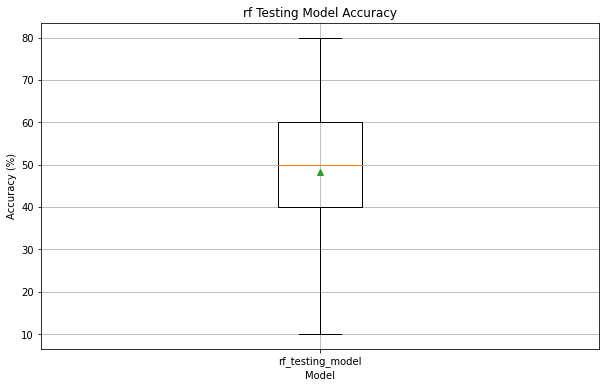

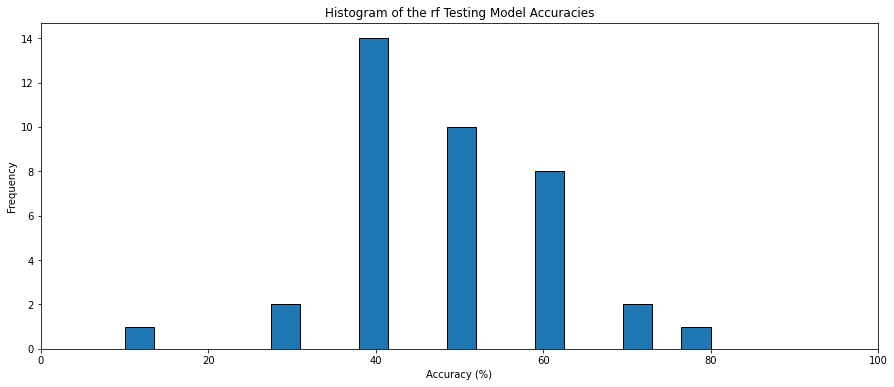

In [20]:
rf_testing_model_accuracies = []
rf_testing_model_total_predictions = []
total_y_results = []

div = 1
matchdays_1 = [i + 1 for i in range(38)]  # There are 38 matchdays this season, for division 1
for matchday in matchdays_1:
    matchday_row = predicting_dataset_to_test.loc[(predicting_dataset_to_test['division'] == div) & 
                                                (predicting_dataset_to_test['matchday'] == matchday)]
    X_predict, y_predict = matchday_row[features], matchday_row[target]
    rf_testing_model_y_pred = rf_testing_model.predict(X_predict)
    
    real_results = y_predict.to_list()
    rf_testing_model_predictions = rf_testing_model_y_pred.tolist()
    total_y_results += real_results
    rf_testing_model_total_predictions += rf_testing_model_predictions
    
    total_matches = len(real_results)
    rf_testing_model_total_predicted = 0
    
    for i in range(total_matches):
        if real_results[i] == rf_testing_model_predictions[i]:
            rf_testing_model_total_predicted += 1
    
    rf_testing_model_accuracies.append(rf_testing_model_total_predicted * 100 / total_matches)

# Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(rf_testing_model_accuracies, labels=['rf_testing_model'], showmeans=True)
plt.title('rf Testing Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.grid(True)

# Histogram
plt.figure(figsize=(15, 6))
plt.hist(rf_testing_model_accuracies, bins=20, edgecolor='black')
plt.title('Histogram of the rf Testing Model Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Frequency')
plt.xlim(0, 100)

plt.show()


We can observe different things here:
1. the mean accuracy through all the matchdays is about 50%;

2. the middle boxes suggest that half of the accuracies span between 40 and 60%, which is pretty good;

3. a few matchdays are predicted with a 70% accuracy, while others at 30%. It probably contemplates easily and difficultly predictable matchdays, and such scores are realistic. Not bad!

### Mispredictions

Now, let's take a look at the confusion matrix to check how many times the model mispredicted a result:

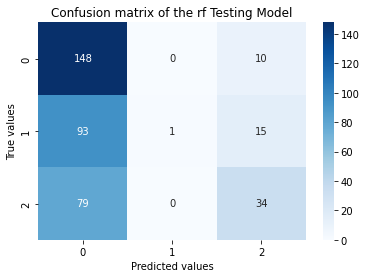

In [21]:
rf_testing_model_cm = confusion_matrix(total_y_results, rf_testing_model_total_predictions)
sns.heatmap(rf_testing_model_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix of the rf Testing Model')
plt.xlabel('Predicted values')
plt.ylabel('True values')

plt.show()

An immediate glance at the matrix leads to some conclusions:

1. the vast majority of the matches with a home-win were correctly predicted. Nice!
2. a tie is practically never predicted - terrible!
3. an away-win is correctly predicted only a third of the times - not satisfactory.
4. in general, the model shows a strong bias towards predicting a home win.

The reason behind this behavior probably resides in the actual result distribution: 
Analyzing the dataset, we had discovered that a home-win is the most frequent result (52.8%), while ties (25.8%) and away wins (21.7%) fairly share the remaining occurrencies.

This, by the way, does not explain why draws and away-wins are predicted with a so different likelihood.

We can plot two histograms and compare real VS predicted results:   
This only shows such tendencies in a different flavor.

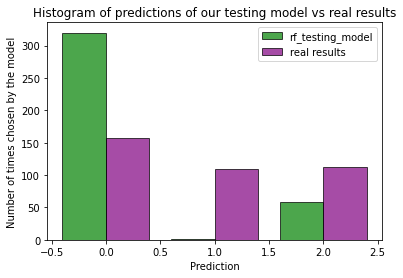

In [22]:
plt.hist([rf_testing_model_total_predictions, total_y_results], bins=[-0.5, 0.5, 1.5, 2.5], alpha=0.7, color=['green', 'purple'] , edgecolor='black')

plt.xlabel('Prediction')
plt.ylabel('Number of times chosen by the model')
plt.title('Histogram of predictions of our testing model vs real results')
plt.legend(['rf_testing_model', 'real results'])

plt.show()

## Observations on other models

One curious observation must be commented. When it comes to predict the results of this last season, some other models perform better. It is the case of these 3:

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

features = ['season', 'division', 'matchday', 'weekday', 'time', 'team', 'rival', 'last_5_results_local','last_5_results_rival']
target = "winner"
X, y = training_dataset_to_test[features], training_dataset_to_test[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [24]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_model_y_pred = gb_model.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, gb_model_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, gb_model_y_pred)}")
print(f"R^2: {r2_score(y_test, gb_model_y_pred)}")

RMSE: 1.09197026052967
MAPE: 401151985810911.56
R^2: -0.7371143474041706


In [25]:
rf_model_v2 = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=15)
rf_model_v2.fit(X_train, y_train)
rf_model_v2_y_pred = rf_model_v2.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, rf_model_v2_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, rf_model_v2_y_pred)}")
print(f"R^2: {r2_score(y_test, rf_model_v2_y_pred)}")

RMSE: 1.1030620305451564
MAPE: 636494484153312.6
R^2: -0.7725833156529609


In [26]:
voting_model = VotingClassifier(estimators=[('gb', gb_model),
                                            ('rf1', rf_model_v2),
                                            ('rf2', rf_model)],
                                            voting='hard')
voting_model.fit(X_train, y_train)
voting_model_y_pred = voting_model.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, voting_model_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, voting_model_y_pred)}")
print(f"R^2: {r2_score(y_test, voting_model_y_pred)}")

RMSE: 1.1097708992990925
MAPE: 288829429783856.44
R^2: -0.7942107353168573


The first one is a Gradient Boosting model without tuning the hyperparameters. The second one is another version of a Random Forest Model, and the third one is a Voting model, which takes the most predicted results between our model and these two presented. 

Look at the predictions of each one, compared to our chosen model.

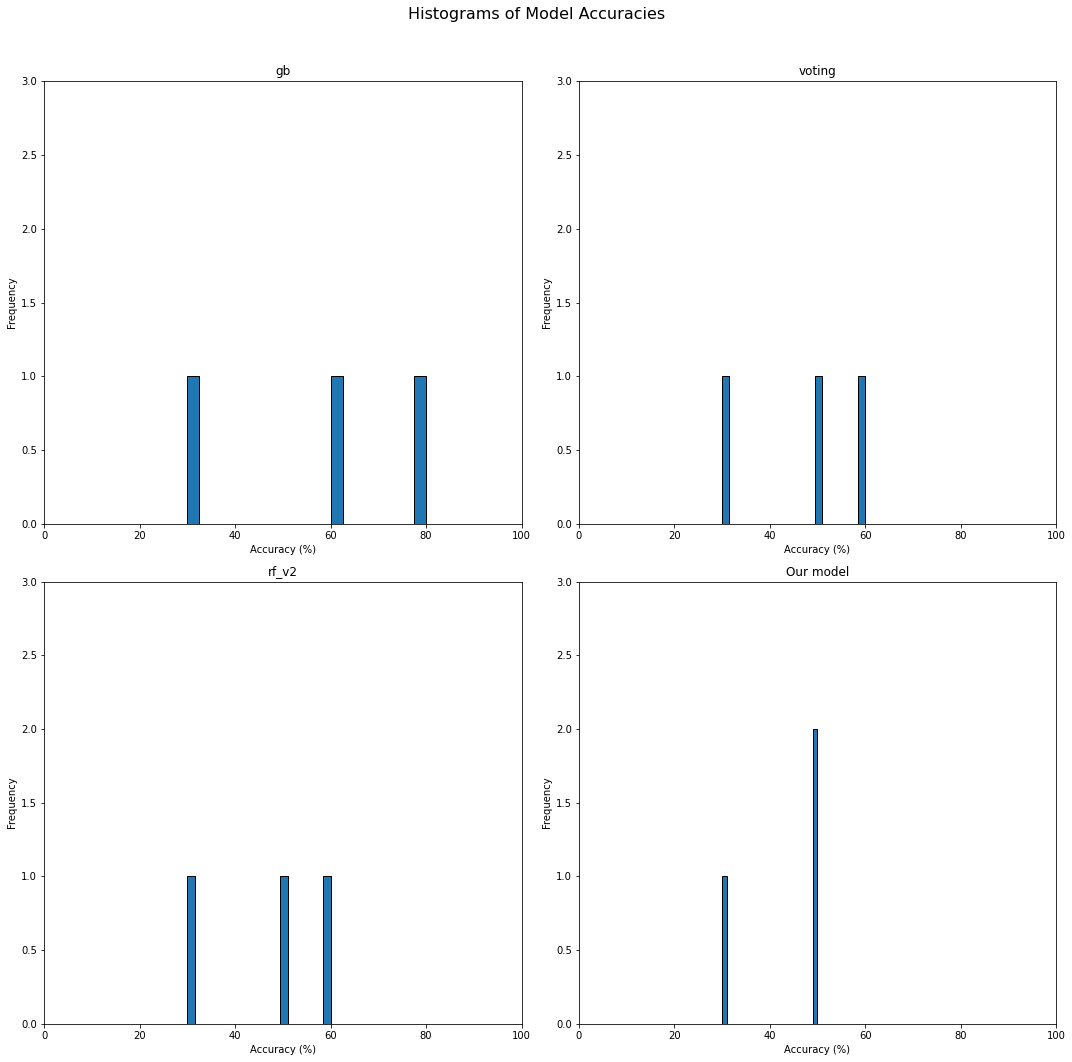

In [27]:
voting_accuracies = []
gb_accuracies = []
rf_v2_accuracies = []
rf_accuracies = []
voting_total_predictions = []
gb_total_predictions = []
rf_v2_total_predictions = []
rf_total_predictions = []
total_y_results = []

div = 1
matchdays_1 = [i + 1 for i in range(3)]
for matchday in matchdays_1:
    matchday_predict = predicting_dataset.loc[(predicting_dataset['division'] == div) & 
                                            (predicting_dataset['matchday'] == matchday)]
    X_predict, y_predict = matchday_predict[features], matchday_predict[target]
    voting_y_pred = voting_model.predict(X_predict)
    gb_y_pred = gb_model.predict(X_predict)
    rf_v2_y_pred = rf_model_v2.predict(X_predict)
    rf_y_pred = rf_model.predict(X_predict)
    
    real_results = y_predict.to_list()
    voting_predictions = voting_y_pred.tolist()
    gb_predictions = gb_y_pred.tolist()
    rf_v2_predictions = rf_v2_y_pred.tolist()
    rf_predictions = rf_y_pred.tolist()
    total_y_results += real_results
    voting_total_predictions += voting_predictions
    gb_total_predictions += gb_predictions
    rf_v2_total_predictions += rf_v2_predictions
    rf_total_predictions += rf_predictions
    
    total_matches = len(real_results)
    voting_total_predicted = 0
    gb_total_predicted = 0
    rf_v2_total_predicted = 0
    rf_total_predicted = 0
    
    for i in range(total_matches):
        if real_results[i] == voting_predictions[i]:
            voting_total_predicted += 1
        if real_results[i] == gb_predictions[i]:
            gb_total_predicted += 1
        if real_results[i] == rf_v2_predictions[i]:
            rf_v2_total_predicted += 1
        if real_results[i] == rf_predictions[i]:
            rf_total_predicted += 1
    
    voting_accuracies.append(voting_total_predicted * 100 / total_matches)
    gb_accuracies.append(gb_total_predicted * 100 / total_matches)
    rf_v2_accuracies.append(rf_v2_total_predicted * 100 / total_matches)
    rf_accuracies.append(rf_total_predicted * 100 / total_matches)

models = ['voting', 'gb', 'rf_v2', 'Our model']
accuracies = [voting_accuracies, gb_accuracies,
            rf_v2_accuracies, rf_accuracies]

mean_accuracies = [mean(acc) for acc in accuracies]

sorted_indices = sorted(range(len(mean_accuracies)), key=lambda k: mean_accuracies[k], reverse=True)
sorted_models = [models[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
fig.suptitle('Histograms of Model Accuracies', fontsize=16)

for i in range(2):
    for j in range(2):
        model_index = i * 2 + j
        axes[i, j].hist(sorted_accuracies[model_index], bins=20, edgecolor='black')
        axes[i, j].set_title(sorted_models[model_index])
        axes[i, j].set_xlabel('Accuracy (%)')
        axes[i, j].set_ylabel('Frequency')
        axes[i, j].set_xlim(0, 100)
        axes[i, j].set_ylim(0, 3)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])


plt.show()
    

As we can see, the other models have made better predictions than our model for these 3 matchdays. Look at the Gradient Boosting model, with even a 60 and 80% of accuracy. In fact, for the 3th matchday:

In [28]:
div = 1
matchday = 3
matchday_predict = predicting_dataset.loc[(predicting_dataset['division'] == div) &
                                        (predicting_dataset['matchday'] == matchday)]
X_predict, y_predict = matchday_predict[features], matchday_predict[target]
gb_y_pred = gb_model.predict(X_predict)
voting_y_pred = voting_model.predict(X_predict)
rf_v2_y_pred = rf_model_v2.predict(X_predict)
rf_y_pred = rf_model.predict(X_predict)
real_results = y_predict.to_list()
gb_predictions = gb_y_pred.tolist()
voting_predictions = voting_y_pred.tolist()
rf_v2_predictions = rf_v2_y_pred.tolist()
rf_predictions = rf_y_pred.tolist()


total_matches = len(real_results)
gb_total_predicted = 0
voting_total_predicted = 0
rf_v2_total_predicted = 0
rf_total_predicted = 0

for i in range(total_matches):
    if real_results[i] == voting_predictions[i]:
        voting_total_predicted += 1
    if real_results[i] == gb_predictions[i]:
        gb_total_predicted += 1
    if real_results[i] == rf_v2_predictions[i]:
        rf_v2_total_predicted += 1
    if real_results[i] == rf_predictions[i]:
        rf_total_predicted += 1
        
gb_accuracy = gb_total_predicted * 100 / total_matches
voting_accuracy = voting_total_predicted * 100 / total_matches
rf_v2_accuracy = rf_v2_total_predicted * 100 / total_matches
rf_accuracy = rf_total_predicted * 100 / total_matches
print(f"gb model has a {gb_accuracy}% accuracy for division {div} and matchday {matchday}\n")
print(f"gb model has a {voting_accuracy}% accuracy for division {div} and matchday {matchday}\n")
print(f"gb model has a {rf_v2_accuracy}% accuracy for division {div} and matchday {matchday}\n")
print(f"gb model has a {rf_accuracy}% accuracy for division {div} and matchday {matchday}\n")

gb model has a 80.0% accuracy for division 1 and matchday 3

gb model has a 60.0% accuracy for division 1 and matchday 3

gb model has a 60.0% accuracy for division 1 and matchday 3

gb model has a 50.0% accuracy for division 1 and matchday 3



We can see that our model got the worst prediction accuracy.

However, analyzing how these four models predicted the whole 2019-2020 season, we found out our model got the best results.  
For this reason, we did not think it would be worth it to exchange it.

Here we can began finding which features had the most significant impact on predictions utilizing the feature importance attribute of oure trained random forest model. Than we visualize feature importance using a bar chart to easily interpret the relative importance of each feature. We observe, as expected, that the teams are the most important. After the matchday, season  and time seem to have more importance in our random forest model.

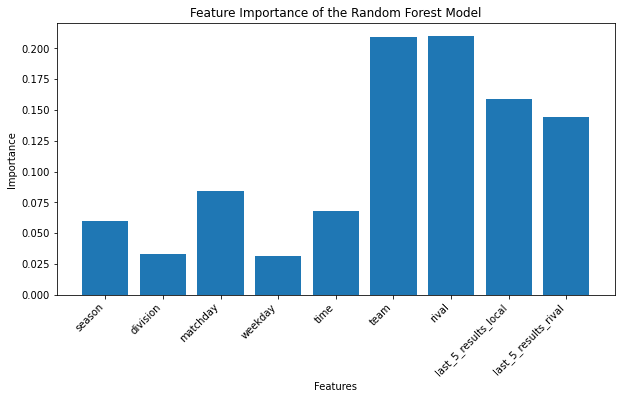

In [29]:
feature_importances = rf_testing_model.feature_importances_
features = predicting_dataset_to_test[features].columns

# Create a bar chart for feature importance
plt.figure(figsize=(10, 5))
plt.bar(features, feature_importances)
plt.title('Feature Importance of the Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()


We have now decided to perform cross-validation to evaluate the model.
The result we have obtained, "Cross-Validation Scores", is the performance of the model in each of the iterations of the cross-validation. In your case, it seems that you have used 5-fold cross-validation, since there are five values in the list.

The specific values (0.29691211, 0.48456057, 0.49643705, 0.47624703, 0.46852732) are the scores of the model in each of the divisions of the data set. These scores represent how the model performs on different subsets of the data during the cross-validation process.

The "Mean CV Score" is simply the average of these scores. In oure case, it is 0.44453681710213766. This provides an overall measure of the average model performance across all folds of the cross-validation.

In summary, cross-validation gives a more robust assessment of model's performance by training and evaluating it on multiple data sets, which helps reduce the possibility of overfitting to a specific data set. In this case, the Mean CV Score suggests that, on average, oure model performs 44.45%.

In [30]:
from sklearn.model_selection import cross_val_score

# Assuming X and y are your complete dataset
cv_scores = cross_val_score(rf_testing_model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {cv_scores.mean()}')


Cross-Validation Scores: [0.29691211 0.48456057 0.49643705 0.47624703 0.46852732]
Mean CV Score: 0.44453681710213766


### Variance inflation factor (VIF)

Here first code filters out numeric characteristics, since VIF only applies to numeric variables. Then calculates the VIF for each numeric characteristic and displays the results in a horizontal bar chart.
In the resulting graph, the bars represent the VIF value for each characteristic. High VIF values indicate significant multicollinearity. You may consider addressing features with high VIF to improve the stability of the model, either by removing some of them or by using more advanced techniques to handle multicollinearity.


Multicollinearity is a phenomenon in which two or more predictor variables in a regression model are highly correlated with each other. Significant multicollinearity refers to cases in which this correlation is strong enough to negatively affect the stability and reliability of the model.

In our case a high VIF (Variance Inflation Factor) for the "season", "time" and "division" variables indicates that these variables are highly correlated with each other in the model. Significant multicollinearity among these variables can have several negative effects on oure regression model, such as instability of the coefficients and decreased precision of the estimates.

The solution may be to eliminate some of these variables or try to combine them into one.



In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Característica"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]


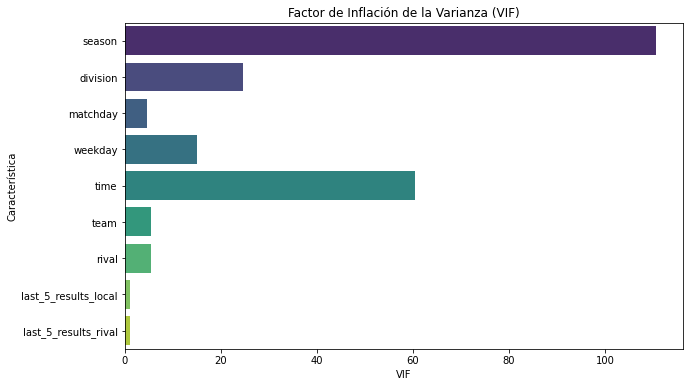

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x='VIF', y='Característica', data=vif_data, orient='h', palette='viridis')
plt.title('Factor de Inflación de la Varianza (VIF)')
plt.show()